In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.stats as stats

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])

In [3]:
print shape(uni_x)
print uni_x[5]

(100,)
0.2


In [4]:
print shape(uni_x[:, None])
print (uni_x[:, None])[5]

(100, 1)
[ 0.2]


In [5]:
print shape(uni_y)
print type(uni_y)
print uni_y[5]
print type(uni_y)

(100,)
<type 'numpy.ndarray'>
0.2
<type 'numpy.ndarray'>


In [6]:
print shape(uni_y[:, None])
print (uni_y[:, None])[5]
print type((uni_y[:, None])[5])

(100, 1)
[ 0.2]
<type 'numpy.ndarray'>


In [7]:
print(shape(M))
print(M[50,50])

(100, 100)
0.04


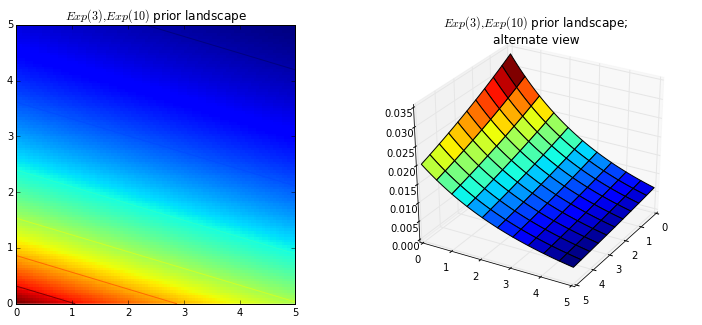

In [8]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view")

#"Unsupervised clustering using a mixture model" 

[ 115.85679142  152.26153716  178.87449059  162.93500815  107.02820697
  105.19141146  118.38288501  125.3769803   102.88054011  206.71326136] ...
(300,)
300


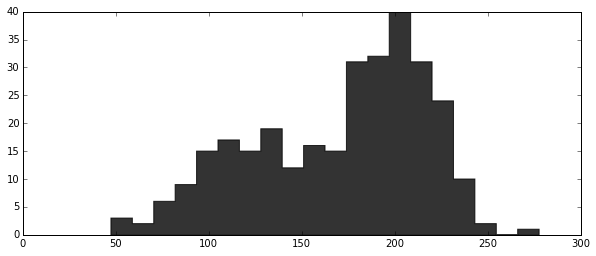

In [9]:
figsize(10, 4)
data = np.loadtxt('data/mixture_data.csv', delimiter=',')

plt.hist(data, bins=20, color='k', histtype='stepfilled', alpha=0.8)
plt.ylim([0, None])
print data[:10], '...'
print data.shape  # (300,) - I think this is a tuple with one element
print data.shape[0]

In [10]:
import pymc as pm

p = pm.Uniform("p", 0, 1)

assignment = pm.Categorical("assignment", [p, 1 - p], size=data.shape[0])
print "prior assignment, with p = %.2f:" % p.value
print assignment.value[:10], "..."

prior assignment, with p = 0.81:
[0 0 0 0 0 0 0 0 1 0] ...


In [11]:
taus = 1.0 / pm.Uniform("stds", 0, 100, size=2) ** 2
centers = pm.Normal("centers", [120, 190], [0.01, 0.01], size=2)

"""
The below deterministic functions map an assignment, in this case 0 or 1,
to a set of parameters, located in the (1,2) arrays `taus` and `centers`.
"""

@pm.deterministic
def center_i(assignment=assignment, centers=centers):
    return centers[assignment]

@pm.deterministic
def tau_i(assignment=assignment, taus=taus):
    return taus[assignment]

print "Random assignments: ", assignment.value[:4], "..."
print "Assigned center: ", center_i.value[:4], "..."
print "Assigned precision: ", tau_i.value[:4], "..."

Random assignments:  [0 0 0 0] ...
Assigned center:  [ 105.27081335  105.27081335  105.27081335  105.27081335] ...
Assigned precision:  [ 0.00017663  0.00017663  0.00017663  0.00017663] ...


In [12]:
obs = pm.Normal('obs', center_i, tau_i, value=data, observed=True)

model = pm.Model([p, assignment, obs, taus, centers])

In [13]:
mcmc = pm.MCMC(model)
mcmc.sample(50000)

 [-----------------100%-----------------] 50000 of 50000 complete in 21.8 sec

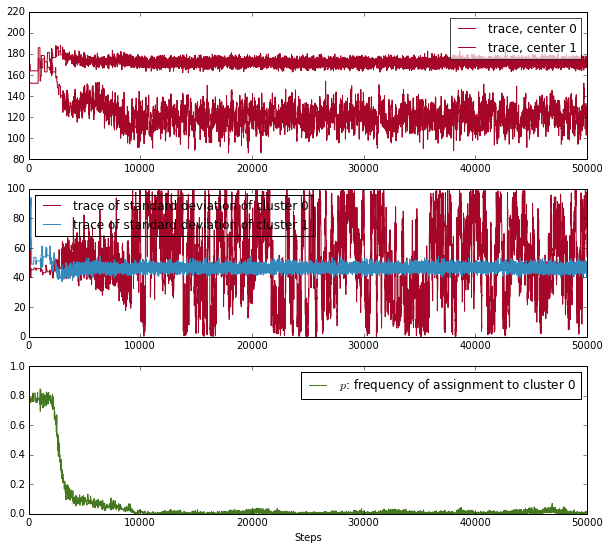

In [14]:
figsize(10, 9)
plt.subplot(311)
lw=1
center_trace = mcmc.trace("centers")[:]

# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] \
if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]
    
plt.plot(center_trace[:,0], label='trace, center 0', c=colors[0], lw=lw)
plt.plot(center_trace[:,1], label='trace, center 1', c=colors[0], lw=lw)
leg = plt.legend(loc='upper right')
leg.get_frame().set_alpha(0.7)
                          
plt.subplot(312)
std_trace = mcmc.trace("stds")[:]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = mcmc.trace("p")[:]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color="#467821", lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend()

In [118]:
mcmc.sample(100000)

 [-----------------100%-----------------] 100000 of 100000 complete in 45.6 sec

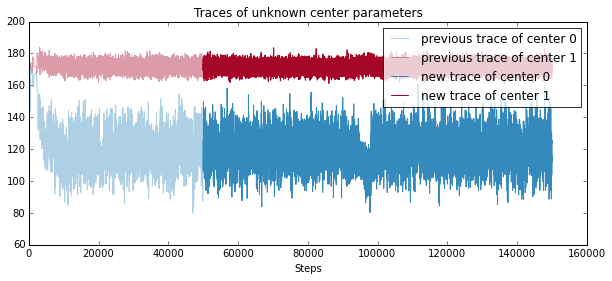

In [119]:
figsize(10, 4)
center_trace = mcmc.trace("centers", chain=1)[:]
prev_center_trace = mcmc.trace("centers", chain=0)[:]

x = np.arange(50000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(50000, 150000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps")

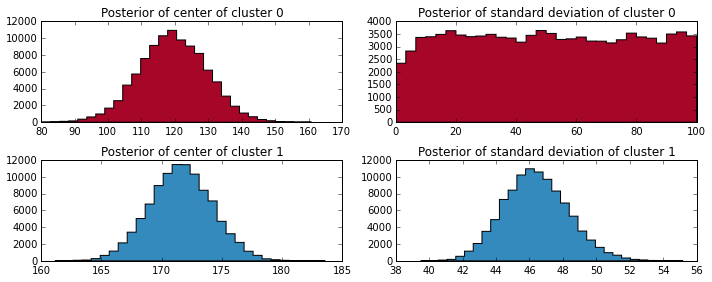

In [120]:
figsize(10.0, 4)
std_trace = mcmc.trace("stds")[:]

_i = [1, 2, 3, 0]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

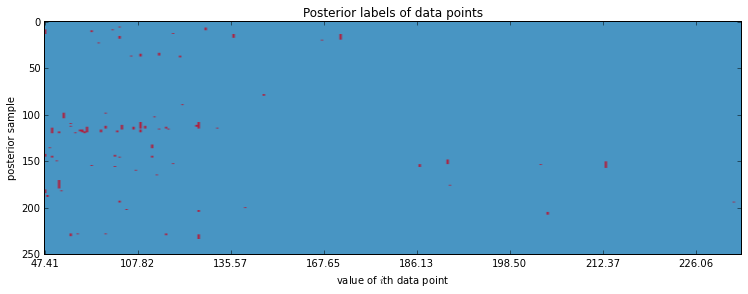

In [121]:
import matplotlib as mpl
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(mcmc.trace("assignment")[::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points")

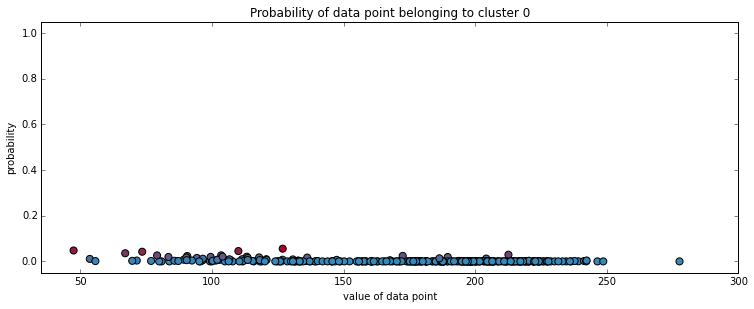

In [122]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = mcmc.trace("assignment")[:]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point")

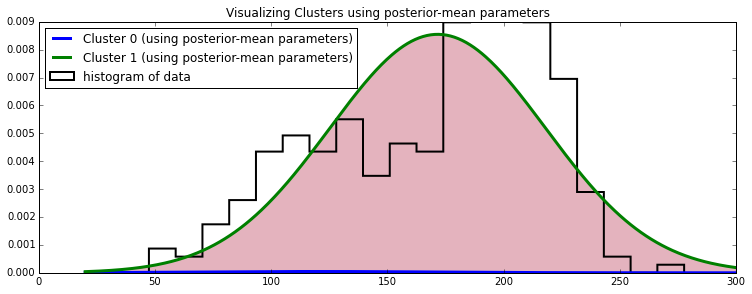

In [123]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = mcmc.trace("p")[:].mean()

plt.hist(data, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters")

In [124]:
norm_pdf = stats.norm.pdf
p_trace = mcmc.trace("p")[:]
x = 175

v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])

print "Probability of belonging to cluster 1:", v.mean()

Probability of belonging to cluster 1: 0.0
